# Contextual affix CRF coarse-grained experiments analysis

In [15]:
from collections import defaultdict
import os
import pprint

from pymongo import MongoClient
from scipy.stats import f_oneway, ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')

%matplotlib inline

In [2]:
client = MongoClient(os.environ['SACRED_MONGO_URL'])
db = client[os.environ['SACRED_DB_NAME']]

In [3]:
run_criteria = {
    'experiment.name': 'id-pos-tagging-ctx-affix-crf-coarse',
    'meta.command': 'evaluate',
    'status': 'COMPLETED',
}

In [4]:
db.runs.count(run_criteria)

300

In [5]:
data = defaultdict(list)
for run in db.runs.find(run_criteria):
    data['run_id'].append(run['_id'])
    for conf in 'c2 min_freq use_prefix use_suffix use_wordshape window'.split():
        data[conf].append(run['config'][conf])
    metric = db.metrics.find_one({'run_id': run['_id'], 'name': 'f1'})
    if metric is not None:
        if len(metric['values']) != 1:
            print(f"run {run['_id']} metric f1 has length != 1, taking the last one")
        data['f1'].append(metric['values'][-1])

In [6]:
df = pd.DataFrame(data)
len(df)

300

In [7]:
df.head()

,c2,f1,min_freq,run_id,use_prefix,use_suffix,use_wordshape,window
0,0.010302,0.871670,7,349,False,False,False,0
1,58.010135,0.804351,7,351,False,True,True,5
2,74.364112,0.688920,10,353,False,False,False,2
3,0.114628,0.933339,3,354,True,True,False,0
4,0.008993,0.925099,10,359,True,False,False,1


The F1 score is from the dev set.

## Analyzing binary variables

### use_prefix

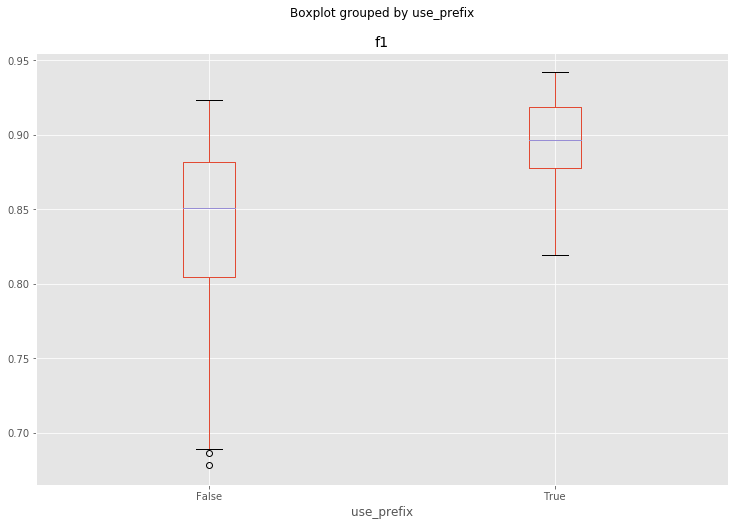

In [8]:
df.boxplot(column='f1', by='use_prefix', figsize=(12, 8))

It seems clear that `use_prefix=True` is better than `use_prefix=False`.

### use_suffix

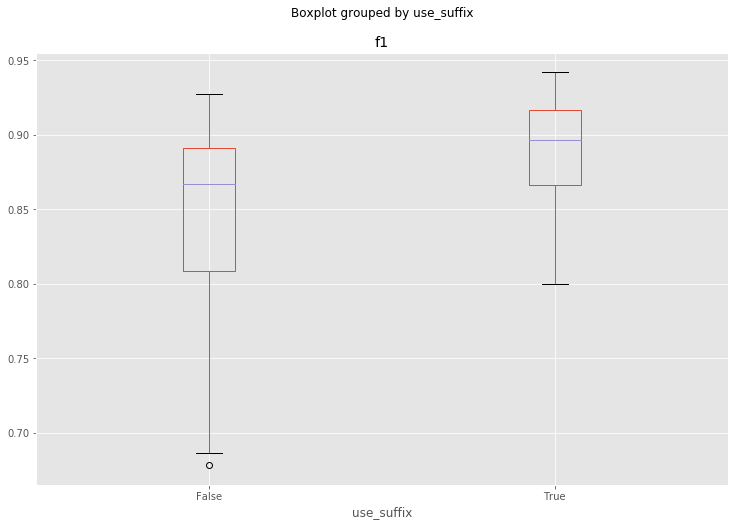

In [9]:
df.boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [11]:
ttest_ind(df[df.use_suffix]['f1'], df[~df.use_suffix]['f1'])

Ttest_indResult(statistic=8.02131537806119, pvalue=2.415155882958715e-14)

It seems clear as well that `use_suffix=True` is better than `use_suffix=False`.

### use_wordshape

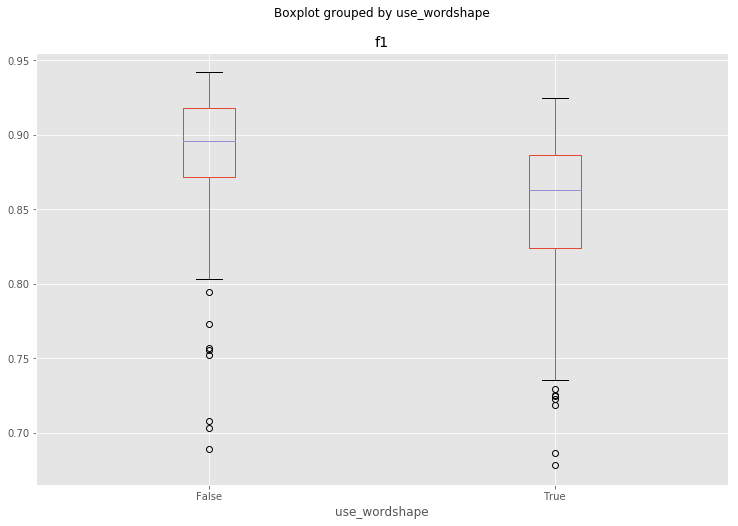

In [12]:
df.boxplot(column='f1', by='use_wordshape', figsize=(12, 8))

In [13]:
ttest_ind(df[df.use_wordshape]['f1'], df[~df.use_wordshape]['f1'])

Ttest_indResult(statistic=-7.023491307096119, pvalue=1.4711825081538353e-11)

It seems that wordshape is not a useful feature. It is better to set `use_wordshape=False`.

## Analyzing multinomial variables

### min_freq

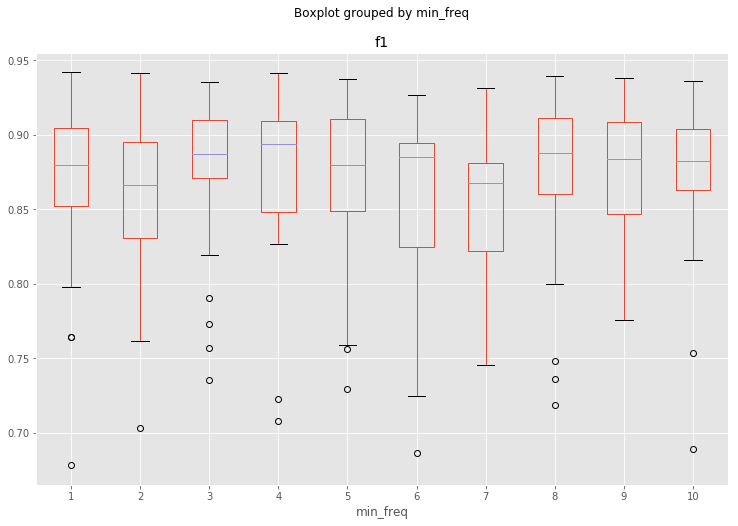

In [14]:
df.boxplot(column='f1', by='min_freq', figsize=(12, 8))

In [16]:
samples = []
for min_freq in df.min_freq.unique():
    samples.append(df[df.min_freq == min_freq]['f1'])
f_oneway(*samples)

F_onewayResult(statistic=0.6390893944115695, pvalue=0.7632939664079864)

There seems no difference among different values for `min_freq`. So, maybe we'll just use the default value of 1.

### window

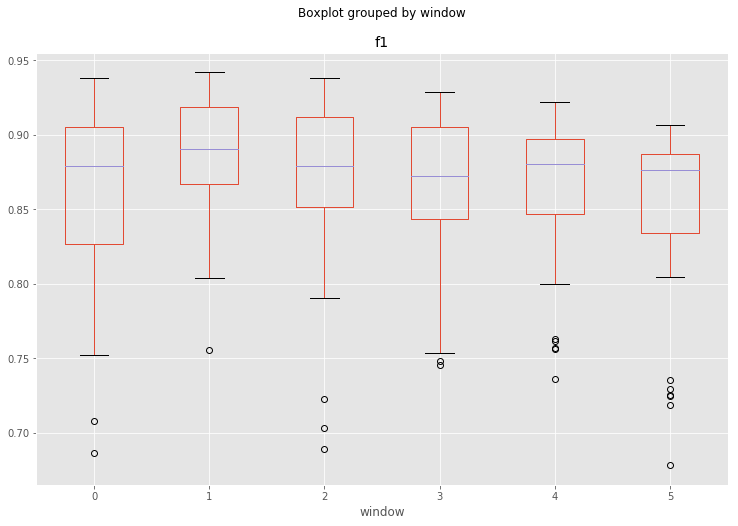

In [17]:
df.boxplot(column='f1', by='window', figsize=(12, 8))

In [18]:
samples = []
for window in df.window.unique():
    samples.append(df[df.window == window]['f1'])
f_oneway(*samples)

F_onewayResult(statistic=3.1447735193211184, pvalue=0.00879970533225635)

There is significant difference when varying `window` value as the p-value is lower than 0.05. But from the boxplot, it is not clear what the best range is. Thus, we'll keep this range for random search.

## Analyzing continuous variables

### c2

In [19]:
df['log10_c2'] = np.log10(df.c2)

In [20]:
df.head()

,c2,f1,min_freq,run_id,use_prefix,use_suffix,use_wordshape,window,log10_c2
0,0.010302,0.871670,7,349,False,False,False,0,-1.987063
1,58.010135,0.804351,7,351,False,True,True,5,1.763504
2,74.364112,0.688920,10,353,False,False,False,2,1.871363
3,0.114628,0.933339,3,354,True,True,False,0,-0.940708
4,0.008993,0.925099,10,359,True,False,False,1,-2.046092


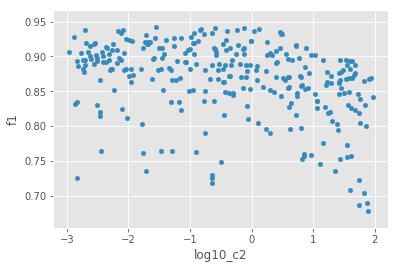

In [22]:
df.plot.scatter(x='log10_c2', y='f1')

It is not too clear if there is a linear trend, but we see that the F1 score seems to decrease for `log10_c2` larger or equal to 0. Thus, the better range to randomize is probably [-3, 0].